In [23]:
import pandas as pd
import numpy as np
import shap
import json
import pickle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [24]:
# load dataset
df = pd.read_csv('../../datasets/atis_dataset_preprocessed.csv', sep=';')

In [ ]:
# define label columns
label_columns = ['ILS', 'RNAV', 'RNP', 'VISUAL']

# # define features and targets
X = df.drop(columns=label_columns + ['airport_icao', 'runway_designator_side', 'weather_phenomenon', 
                                'runway_designator_number', 'rvr_tendency', 'runway_ils_category'])
# X = df.drop(columns=label_columns + [
#     'airport_icao', 
#     'runway_designator_side', 
#     'weather_phenomenon', 
#     'runway_designator_number', 
#     'rvr_tendency', 
#     'runway_ils_category'
# ])

# one-hot encode features that are categorical
X = pd.get_dummies(X, columns=['airport_icao', 'runway_designator_side', 'weather_phenomenon', 
                                'runway_designator_number', 'rvr_tendency', 'runway_ils_category'])

In [26]:
y = df[label_columns]

In [27]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# build and train multi-label model
model = OneVsRestClassifier(XGBClassifier(n_estimators=200, 
                                        learning_rate=0.05, 
                                        max_depth=8, 
                                        subsample=0.9, 
                                        colsample_bytree=0.6, 
                                        eval_metric='logloss'))

# build and train multi-label model
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [29]:
# save trained model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
# features in order
feature_order = list(X.columns)

# save to json
with open("../../app/trained-model/feature_order.json", "w") as f:
    json.dump(feature_order, f)

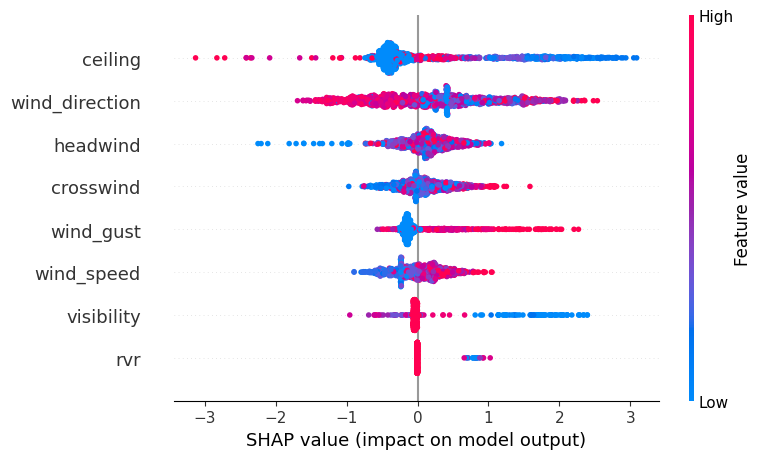

In [31]:
# ILS SHAP
explainer_ILS = shap.TreeExplainer(model.estimators_[0])
shap_ILS = explainer_ILS.shap_values(X_test)
shap.summary_plot(shap_ILS, X_test)

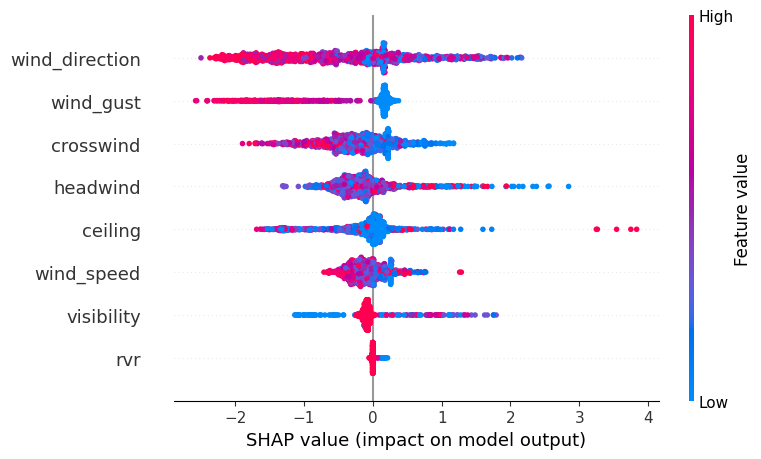

In [32]:
# RNAV SHAP
explainer_RNAV = shap.TreeExplainer(model.estimators_[1])
shap_RNAV = explainer_RNAV.shap_values(X_test)
shap.summary_plot(shap_RNAV, X_test)

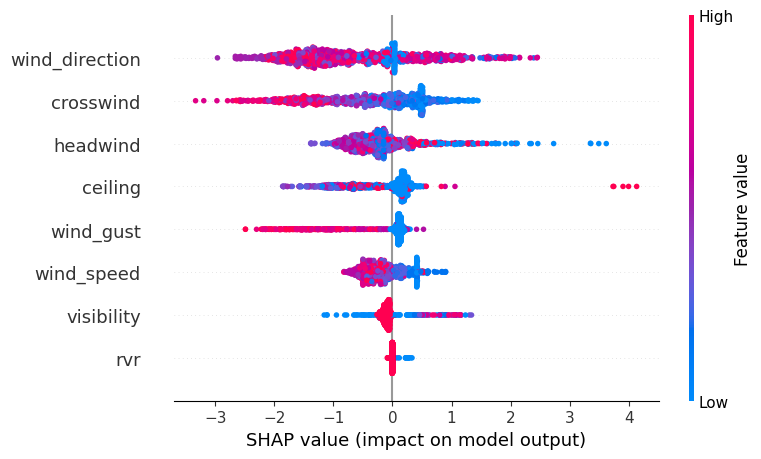

In [33]:
# RNP SHAP
explainer_RNP = shap.TreeExplainer(model.estimators_[2])
shap_RNP = explainer_RNP.shap_values(X_test)
shap.summary_plot(shap_RNP, X_test)

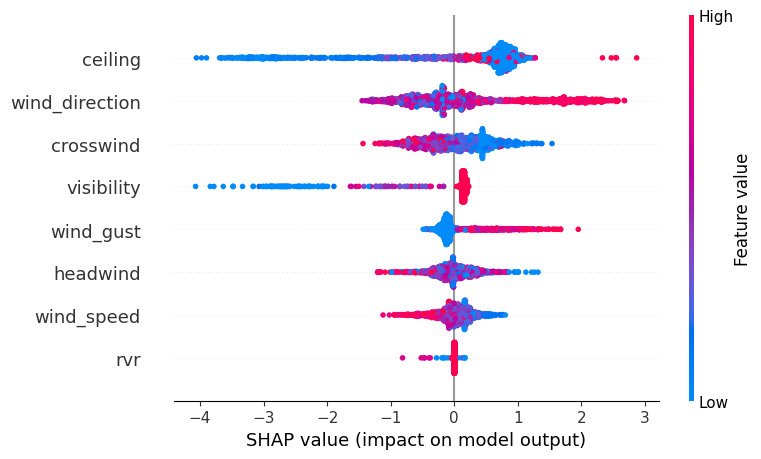

In [34]:
# VISUAL SHAP
explainer_VISUAL = shap.TreeExplainer(model.estimators_[3])
shap_VISUAL = explainer_VISUAL.shap_values(X_test)
shap.summary_plot(shap_VISUAL, X_test)

In [35]:
# predict and evaluate
y_pred = model.predict(X_test)
empty_mask = y_pred.sum(axis=1) == 0
no_predictions = np.sum(empty_mask)
print(f"Samples with no predicted labels: {no_predictions} out of {len(y_pred)}")
print(X_test[empty_mask])
print(classification_report(y_test, y_pred, target_names=label_columns, zero_division=0))

Samples with no predicted labels: 2 out of 1319
      visibility  wind_speed  wind_gust  wind_direction     rvr  headwind  \
1426        10.0           5          0             140  6000.0      -3.8   
553         10.0          17         24             290  6000.0      16.0   

      crosswind  ceiling  
1426        3.2  17000.0  
553         5.8     -1.0  
              precision    recall  f1-score   support

         ILS       0.83      0.94      0.88       950
        RNAV       0.88      0.47      0.61       159
         RNP       0.94      0.49      0.64       105
      VISUAL       0.88      0.96      0.92       880

   micro avg       0.86      0.89      0.87      2094
   macro avg       0.88      0.71      0.76      2094
weighted avg       0.86      0.89      0.86      2094
 samples avg       0.86      0.91      0.87      2094

